<a href="https://colab.research.google.com/github/OlesyaLisiy/Introduction-to-Neural-Networks/blob/main/HW_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Урок 8. GAN
Обучите нейронную сеть любой архитектуры на каком-то производственном датасете
Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.
Можно сегментацию по Северсталии

In [1]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau

from keras.models import Model
from efficientnet.tfkeras import EfficientNetB1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ROWS = 128
COLS = 128
SHAPE = (ROWS, COLS)
DATA_PATH = '/content/drive/MyDrive/Введение в нейронные сети GB/train_images'

In [5]:
def rle_decode(mask_rle, shape: tuple = (256, 1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(data: pd.DataFrame, image_name: str, shape: tuple = (256, 1600)):
    encoded_masks = data.loc[data['ImageId'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1]), dtype=np.float32)
    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :] = mask
    return masks

In [6]:
def show_images(image, mask, pred):
  if pred is not None:
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[2].imshow(pred)
  else:
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  ax[0].imshow(image)
  ax[1].imshow(mask)
  plt.show()

In [7]:
images = []
classes = []
masks = []

data = pd.read_csv('/content/drive/MyDrive/Введение в нейронные сети GB/train.csv')
for img, ClassId, EncodedPixels in tqdm(data.values):
    try:
      image = cv2.imread('/content/drive/MyDrive/Введение в нейронные сети GB//train_images/{}'.format(img))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, SHAPE)
      images.append(image)
      classes.append(ClassId)
      mask = make_mask(data, img)
      mask = cv2.resize(mask, SHAPE)
      masks.append(mask)
    except:
      continue

100%|██████████| 7095/7095 [42:54<00:00,  2.76it/s]


In [8]:
len(images), len(classes), len(masks)

(7095, 7095, 7095)

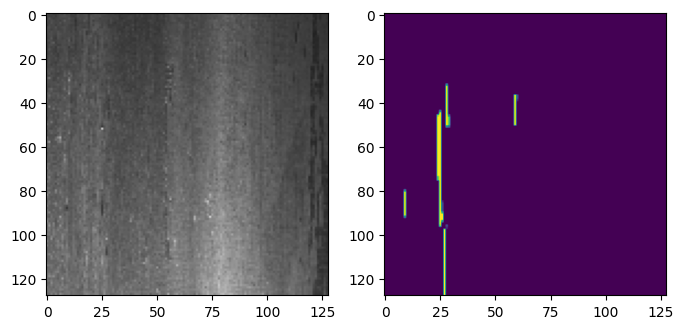

In [10]:
show_images(images[0], masks[0], None)

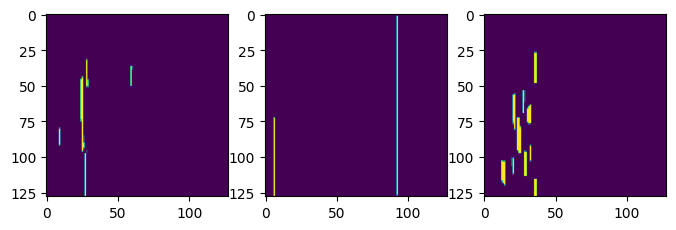

In [11]:
show_images(masks[0], masks[1], masks[2])

In [13]:
encoder = LabelEncoder()

In [14]:
x = np.array(images)
# x = x / 255

c = encoder.fit_transform(classes)
c = to_categorical(c)

m = np.array(masks)

In [15]:
x_train, x_test, c_train, c_test, m_train, m_test = train_test_split(
    x,
    c,
    m,
    test_size=0.2,
#    stratify=c,
    shuffle=True)

In [16]:
print(x_train.shape, c_train.shape, m_train.shape)

(5676, 128, 128, 3) (5676, 4) (5676, 128, 128)


In [17]:
num_classes = 1
inputs = tf.keras.layers.Input((ROWS, COLS, 3))

In [18]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

In [19]:
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

In [20]:
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

In [21]:
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

In [22]:
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [23]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

In [24]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

In [25]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

In [26]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

In [27]:
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

In [28]:
seg_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [29]:
seg_history = seg_model.fit(x_train, m_train, epochs=45, batch_size=32, validation_data=(x_test, m_test), callbacks=[lrd])

Epoch 1/45
178/178 [==============================] - 38s 102ms/step - loss: 0.3105 - accuracy: 0.8993 - val_loss: 0.1920 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 2/45
178/178 [==============================] - 13s 73ms/step - loss: 0.1676 - accuracy: 0.9470 - val_loss: 0.1482 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 3/45
178/178 [==============================] - 13s 73ms/step - loss: 0.1474 - accuracy: 0.9500 - val_loss: 0.1430 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 4/45
178/178 [==============================] - 13s 75ms/step - loss: 0.1381 - accuracy: 0.9519 - val_loss: 0.2330 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 5/45
178/178 [==============================] - 13s 75ms/step - loss: 0.1322 - accuracy: 0.9533 - val_loss: 0.1402 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 6/45
178/178 [==============================] - 13s 76ms/step - loss: 0.1281 - accuracy: 0.9542 - val_loss: 0.1262 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 7/45
178/178 [==============================] - 14s

1/1 [==============================] - 1s 695ms/step


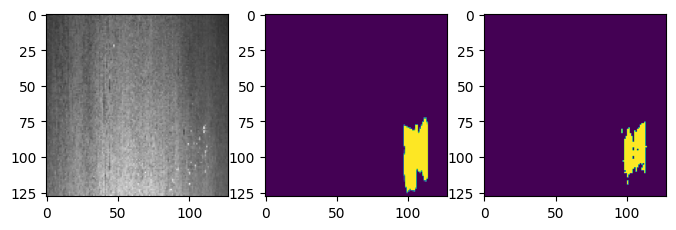

In [30]:
index = random.randint(0, len(x_test))
test_image = x_test[index]
test_mask = m_test[index]
prediction = seg_model.predict(test_image[np.newaxis, ...])[0]
pred_mask = (prediction > 0.5).astype(np.uint8)
show_images(test_image, test_mask, pred_mask)

## Выводы
Мощности домашнего компьютера не позволяют обрабатывать быстро такой массив данных. Очень много времени заняло даже скачивание данных для нейросети, не говоря уже об обучении, поэтому своей главной целью в рамках выполнения этого домашнего задания ставила не создание оптимальной сети, а создание рабочей сети.

Для сегментации изображение преобразовано в градации серого.
Модель без пулинговых и скрытых слоёв на большинстве сеансов показала незначительно лучшие результаты: accuracy c 0.70 до 0.76
Увеличение числа эпох результат не улучшает.

Accuracy начинает колебаться. Вероятно модель находится в состоянии локального минимума, и требуется применить дополнительные средства для упрощения сложности модели. Возможно, это та же причина, по которой обучение на свёрточных слоях не показывает улучшение результатов, т.к. имеет чрезмерную сложность для этой задачи.

Может быть, при упрощении модели больший объём обучающих данных позволит улучшить результаты.